# CNN 孤立词识别

In [1]:
import librosa
import scipy
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")
# print(librosa.__version__)
# print(scipy.__version__)

In [2]:
os.listdir()
os.listdir('data/')

['tensorflow-speech-recognition-challenge']

### 数据预处理

In [3]:
%%time

labels=["yes", "no", "up", "down"]
train_audio_path = 'data/tensorflow-speech-recognition-challenge/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
Wall time: 2min 13s


In [4]:
%%time
# 输出标签转换为整体编码(Encoding Output Label)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(len(classes))

4
Wall time: 6.98 ms


In [5]:
# 热编码 - One-Hot-Encoding
# - 整体编码的标签转换为一个热向量
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))


In [6]:
# 2D 数组 转换成 3D 数组( conv1d 的输入必须是3D数组
all_wave = np.array(all_wave).reshape(-1,8000,1)

### 划分 训练集 和 数据集 8：2

In [7]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)


### 搭建模型 - Conv 1D

In [8]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [9]:
# model.compile 损失函数
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
# 建立 提前停止 和 模型检查点
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
# 存储结果到 best_model.hdf5
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### 训练模型

In [11]:
%%time

history=model.fit(x_tr, y_tr ,epochs=80, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/80
212/212 [==============================] - 32s 147ms/step - loss: 1.3227 - accuracy: 0.3396 - val_loss: 0.8873 - val_accuracy: 0.6175

### 可视化模型性能

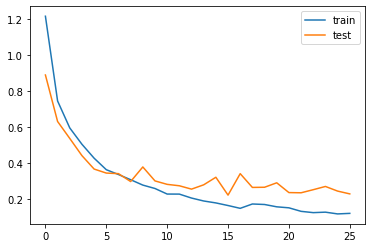

In [12]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 保存模型

In [13]:
model.save("model/best_model.hdf5")

### 加载模型

In [14]:
from keras.models import load_model
model=load_model('model/best_model.hdf5')

### 预测
（测试集上

In [15]:
# 预测函数
import numpy as np
def predict(audio):
    prob=model.predict(audio.reshape(1, 8000, 1))
    index=np.argmax(prob[0])
    return classes[index]


In [16]:
# 预测 验证数据 音频文件

import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: down


In [17]:
print("Text:",predict(samples))

Text: no


In [18]:
%%time

right = wrong = 0
for i in range(len(x_val)) :
    wave_sample = x_val[i].ravel()
    real_label = classes[np.argmax(y_val[i])]
    # ipd.Audio(wave_sample, rate=8000)
    predict_label = predict(wave_sample)
    if(real_label == predict_label):
        right += 1
        # print('yes:', right)
    else:
        wrong +=1
        # print('no', wrong)

Wall time: 1min 54s


In [19]:
print("测试集语音总条数：", len(x_val))
print("预测正确条数：", right)
print("预测错误条数：", wrong)
print("测试集上的正确率：", right/(right + wrong))

测试集语音总条数： 1694
预测正确条数： 1577
预测错误条数： 117
测试集上的正确率： 0.9309327036599764
